## Explore exploit dilemma

For the example of the slot machines in casino, where we want to determine the machine with the highest win rate. We want to play all the machines to get their win rate, however we want to play as many as possible the best slot machine so that we can avoid utilizing time and resources on sub-optimal machines, hence the dilemma.


## Epsilon greedy 

Choose the machine with the highest current sample mean. However, there is a small possibility of choosing the machine randomly.

In [1]:
import numpy as np
import pandas as pd
np.random.seed(1)

In [2]:
np.random.seed(1)
m_prob = [0.1, 0.2, 0.3]
m_winrate = [0,0,0]
m_times = [0,0,0]
ite = 10000
eps = 0.1
get_opt = 0
tot_pts = 0
num_explore = 0
num_exploited = 0

def pull(prob):
  return np.random.rand() < prob


for i in range(1,ite+1):
  machine = 0
  if np.random.random() < eps:
    num_explore += 1
    machine = np.random.randint(len(m_winrate))
  else:
    num_exploited += 1
    machine = np.argmax(m_winrate)
  
  cur = pull(m_prob[machine])
  m_times[machine] += 1
  m_winrate[machine] = ((m_times[machine]-1)*m_winrate[machine] + cur)/m_times[machine] #formula to calculate sample mean

  #see how many times we land on the optimal machine (which has highest true probability, i.e. machine 3)
  if machine == 2:
    get_opt += 1

  tot_pts += cur

print("machine win rate: {}".format(m_winrate))
print("probability we use the actual best machine: ", get_opt/ite)
print('number of times we used each machine: ', m_times)
print("our win rate combined: ", tot_pts/ite)
print("exploited: {}, explored: {}".format(num_exploited, num_explore))

machine win rate: [0.1289398280802294, 0.18720379146919425, 0.2993823816231431]
probability we use the actual best machine:  0.9229
number of times we used each machine:  [349, 422, 9229]
our win rate combined:  0.2887
exploited: 9019, explored: 981


## Optimistic Initial Value

It is similar to the greedy method, except that the initial estimate of the win probability is set to be very high, then as we collect more data, this win rate will converge to the optimal/highest win rate between machines.

In [3]:
np.random.seed(1)
m_prob = [0.1, 0.2, 0.3]
m_winrate = [5,5,5]
m_times = [1,1,1]
ite = 10000
get_opt = 0
tot_pts = 0

def pull(prob):
  return np.random.rand() < prob


for i in range(1,ite+1):
  machine = np.argmax(m_winrate)
  cur = pull(m_prob[machine])
  m_times[machine] += 1
  m_winrate[machine] = ((m_times[machine]-1)*m_winrate[machine] + cur)/m_times[machine] #formula to calculate sample mean

  #see how many times we land on the optimal machine (which has highest true probability, i.e. machine 3)
  if machine == 2:
    get_opt += 1

  tot_pts += cur

print("machine win rate: {}".format(m_winrate))
print("probability we use the actual best machine: ", get_opt/ite)
print('number of times we used each machine: ', m_times)
print("our win rate combined: ", tot_pts/ite)


machine win rate: [0.2916666666666667, 0.2923076923076923, 0.30693968125882515]
probability we use the actual best machine:  0.9913
number of times we used each machine:  [24, 65, 9914]
our win rate combined:  0.3054


The reason why the win rate of the sub-optimal machiens are inaccurate at all is because once they are below the optimal win rate (i.e. win rate of machine 3), they will stop getting selected (i.e. updated) and it will keep choosing machine 3 because we are only being greedy. Hence you can also see that the number of times machine 3 got selected is almost 99% of time.

## Upper Confidence Bound (UCB)

This method is based on the equation of an upper confidence bound, which is the sample mean plus an error term (shown below). 

Initially, the error term is large and the confidence interval is large, so we want to explore and gather more data on this machine. As more data are collected, the upper confidence bound is shrinking closer to its true mean, then I no longer need to explore this machine and I will move to a difference machine. The only time I will keep exploring/returning to this machine is because its actually mean is really high (which is the machine that we want to find)

In [4]:
np.random.seed(1)
m_prob = [0.1, 0.2, 0.3]
m_winrate = [0,0,0]
m_times = [0,0,0]
ite = 10000
get_opt = 0
tot_pts = 0

def pull(prob):
  return np.random.rand() < prob

def ucb(mean, tot_all, tot_single): # this is a heuristic
  return mean + np.sqrt(2*np.log(tot_all)/tot_single)

#initialization for the sample mean, play all the machine once, or just set m_times to array of 1 (only for UCB)
for i in range(len(m_prob)):
  cur = pull(m_prob[i])
  m_times[i]+=1
  m_winrate[i] = ((m_times[i]-1)*m_winrate[i] + cur)/m_times[i]

for i in range(1,ite+1):
  machine = np.argmax([ucb(m_winrate[x], i, m_times[x]) for x in range(len(m_prob))])
  cur = pull(m_prob[machine])
  m_times[machine] += 1
  m_winrate[machine] = ((m_times[machine]-1)*m_winrate[machine] + cur)/m_times[machine] #formula to calculate sample mean

  #see how many times we land on the optimal machine (which has highest true probability, i.e. machine 3)
  if machine == 2:
    get_opt += 1

  tot_pts += cur

print("machine win rate: {}".format(m_winrate))
print("probability we use the actual best machine: ", get_opt/ite)
print('number of times we used each machine: ', m_times)
print("our win rate combined: ", tot_pts/ite)


machine win rate: [0.08527131782945736, 0.20386007237635698, 0.3077613279497528]
probability we use the actual best machine:  0.8915
number of times we used each machine:  [258, 829, 8916]
our win rate combined:  0.2934


## Thompson Sampling theory (preferred)

We use sampling of the posterior distribution for each machine and play the machine that has the max of the sample(). Eventually the machine that has the highest win rate will shrink its confidence interval toward the true mean, and we will prioritize that machine. At the end, we will see that the optimal machine will be used the most of the time and its shape is skinny and tall, while the suboptimal machines are not used that often and will be fat and flat. This means that we do not explore much the suboptimal machines, but we explored just enough to be confident that they are suboptimal. Here we use beta distribution for sampling.

In [5]:
np.random.seed(1)
m_prob = [0.1, 0.2, 0.3]
m_times = [0,0,0]
m_beta_params = [[1,1],[1,1],[1,1]]
ite = 1000
get_opt = 0
tot_pts = 0

def pull(prob):
  return np.random.rand() < prob

def sample(s):
  return np.random.beta(m_beta_params[s][0], m_beta_params[s][1])

for i in range(1,ite+1):
  machine = np.argmax([sample(s) for s in range(len(m_prob))])
  cur = pull(m_prob[machine])
  m_times[machine] += 1

  #posterior become the prior in the next interation
  m_beta_params[machine][0] += cur 
  m_beta_params[machine][1] += 1-cur

  #see how many times we land on the optimal machine (which has highest true probability, i.e. machine 3)
  if machine == 2:
    get_opt += 1

  tot_pts += cur

print("probability we use the actual best machine: ", get_opt/ite)
print('number of times we used each machine: ', m_times)
print("our win rate combined: ", tot_pts/ite)


probability we use the actual best machine:  0.909
number of times we used each machine:  [16, 75, 909]
our win rate combined:  0.286


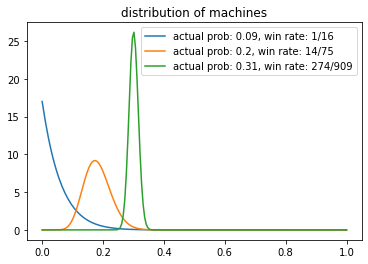

In [6]:
from scipy.stats import beta
import matplotlib.pyplot as plt

x = np.linspace(0,1,200)
for m in range(len(m_prob)):
  y = beta.pdf(x, m_beta_params[m][0], m_beta_params[m][1])
  plt.plot(x,y, label="actual prob: {}, win rate: {}/{}".format(np.round(m_winrate[m],2), m_beta_params[m][0], m_times[m]))
plt.title("distribution of machines")
plt.legend()
plt.show()

# Continue value reward using Thompson sampling

In this case we will be using a Gaussian distribution as our reward distribution, instead of just using binary output like above. 
Note that we will assume unknown mean and known precision, the congujate prior will just be a normal distribution.

In [7]:
np.random.seed(1)
m_prob = [0.1, 0.2, 0.3]
m_times = [0,0,0]
m_tau = [1,1,1]

#Our prior is N(0,1)
m_pred_mean = [0,0,0]
m_lambda = [1,1,1]

sumx = [0,0,0]

ite = 1000
get_opt = 0
tot_pts = 0

def pull(s):
  return np.random.rand() / np.sqrt(m_tau[s]) + m_prob[s] # tau is 1/(sigma^2)

def sample(s):
  return np.random.rand() / np.sqrt(m_lambda[s]) + m_pred_mean[s]

for i in range(1,ite+1):
  machine = np.argmax([sample(s) for s in range(len(m_prob))])
  cur = pull(machine)
  m_times[machine] += 1

  m_lambda[machine] += m_tau[machine]
  sumx[machine] += cur
  m_pred_mean[machine] = m_tau[machine] * sumx[machine] / m_lambda[machine] #assume prior of the mean is 0

  #see how many times we land on the optimal machine (which has highest true probability, i.e. machine 3)
  if machine == 2:
    get_opt += 1

  tot_pts += cur

print("probability we use the actual best machine: ", get_opt/ite)
print('number of times we used each machine: ', m_times)
print("our win rate combined: ", tot_pts/ite)

probability we use the actual best machine:  0.944
number of times we used each machine:  [30, 26, 944]
our win rate combined:  0.8064520446375292


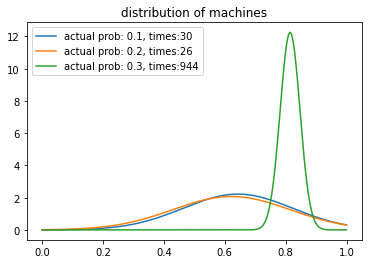

In [8]:
from scipy.stats import norm 

x = np.linspace(0,1,200)
for m in range(len(m_prob)):
  y = norm.pdf(x, m_pred_mean[m], np.sqrt(1/m_lambda[m]))
  plt.plot(x,y, label="actual prob: {}, times:{}".format(m_prob[m], m_times[m]))
plt.title("distribution of machines")
plt.legend()
plt.show()